In [413]:
import pymongo
import os
from pprint import pprint
import nytimes
import urllib, json, csv
from datetime import *
from dateutil.relativedelta import *
import calendar, time
from random import randint
from time import sleep
import pandas as pd
from numpy.random import randn
from pandas import Series, DataFrame
import matplotlib as plt
import seaborn as sns
import re

from __future__ import print_function
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
import statsmodels.api as sm

%matplotlib inline

In [2]:
def nb_name_formatter(path):
    '''creates a formatted list of borough names'''
    names = []
    with open(path, 'rU') as f:
        data = [row for row in csv.reader(f.read().splitlines())]
        for row in data:
            row = row
            names.extend(row)
        return names

def names_no_space(names,code):
        for i, n in enumerate(names):
            names[i-1] = n.replace(' ','')
        return names


#f_path ='/Users/gfsoileau/Metis/Fletcher/bronx_names.csv'

# bx_names = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/bronx_names.csv')
# bx_no_space = names_no_space(bx_names,'BX')
# qn_names = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/queens_names.csv')
# qn_no_space = names_no_space(qn_names,'QN')
# mn_names = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/manh_names.csv')
# mn_no_space = names_no_space(mn_names,'MN')
# bk_names = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/bk_names.csv')
# bk_no_space = names_no_space(bk_names,'BK')
# si_names = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/si_names.csv')
# si_no_space = names_no_space(si_names,'SI')


redo: bk_bedsty,

In [109]:
bk_names = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/bk_names.csv')

In [146]:
print bx_no_space


['Belmont', 'Bronxwood', 'CastleHill', 'CityIsland', 'Co-opCity', 'Concourse', 'CountryClub', 'CrotonaParkEast', 'EastTremont', 'WestFarms', 'Eastchester', 'Edenwald', 'Fordham', 'Highbridge', 'HuntsPoint', 'Kingsbridge', 'KingsbridgeHeights', 'Laconia', 'Longwood', 'Melrose', 'MorrisHeights', 'MorrisPark', 'Morrisania', 'Claremont', 'MottHaven', 'NorthNewYork', 'Norwood', 'Parkchester', 'PelhamBay', 'PelhamGardens', 'PelhamParkway', 'Bronxdale', 'Riverdale', 'Fieldston', 'SpuytenDuyvil', 'Schuylerville', 'Soundview', 'ThrogsNeck', 'LocustPoint', 'Tremont', 'Mt.Hope', 'UniversityHeights', 'VanNest', 'Wakefield', 'WestchesterVillage', 'WestchesterSquare', 'Williamsbridge', 'Woodlawn', 'BedfordPark', 'BedfordPark']


In [3]:
years = [2015,2014,2013,2012,2011,2010,2009,2008,2007]

BK_names = ['Bay Ridge','Bedford-Stuyvesant','Bensonhurst','Bergen Beach','Boerum Hill','Borough Park','Brighton Beach',
           'Brooklyn Heights','Brooklyn Navy Yard','Brownsville','Bushwick','Canarsie','Carroll Gardens',
           'Clinton Hill','Cobble Hill','Coney Island','Crown Heights',
           'Cypress Hills','Ditmas Park','Downtown Brooklyn','DUMBO','Dyker Heights','East New York',
           'East Williamsburg','Farragut','Flatbush','Flatlands','Fort Greene','Fort Hamilton','Gerritsen Beach',
           'Gowanus','Gravesend','Greenpoint','Greenwood Heights','Kensington',
           'Manhattan Beach','Marine Park','Midwood','Mill Basin','New Lots','New Utrecht',
           'Ocean Parkway','Old Mill Basin','Park Slope','Prospect Heights',
           'Prospect Lefferts Gardens','Prospect Park South','Red Hook','Seagate','Sheepshead Bay',
           'Stuyvesant Heights','Sunset Park','Vinegar Hill','White Sands','Williamsburg','Windsor Terrace']


In [267]:
def nyt_api(names, years):
    '''calls nytimes api with a formatted query string and saves json file '''
    search_obj = nytimes.get_article_search_obj ('7ff048af1779e0c12cf7038c3d9476a0:15:56968285')
    for n in names:
        for y in years:
            search_obj.article_search(filename="'"+n+str(y)+".json" "'",q="'"+n+" real estate" "'",begin_date=str(y)+"0101",end_date=str(y)+"1231")  
            
nyt_api(si_names,years)

In [104]:
def format_nyt_dict(path, borough):
    '''format the json files return from the API and insert into mongodb nytimesdb, neighborhood_data.collection.
        Takes the path to directory where files are stored and the borough name'''
    files = os.listdir(path)
    for f in files:
        year = f[-10:-6]
        name_hood = f[1:-10]
        print year, name_hood
        with open(path+f) as json_file:
            print '*' *20
            data = json_file.read().replace('\n', '')
            times_dict = json.loads(data)
            count = 0
            for i in times_dict['response']['docs']:
                print i
                dic = {}
                if i['news_desk'] == 'RealEstate' or i['news_desk'] == 'Metro'and i["section_name"] != "Great Homes & Destinations":
                    count +=1
                    dic['id'] = i['_id']
                    if i['abstract'] is not None:
                        dic['abstract'] = i['abstract'].encode("utf8")
                    dic['headline'] = i['headline']['main'].encode("utf8")
                    dic['desk'] = i['news_desk']
                    dic['date'] = i['pub_date'][0:10] # cutting time of day.
                    dic['section'] = i['section_name']
                    if i['snippet'] is not None:
                        dic['snippet'] = i['snippet'].encode("utf8")
                    dic['source'] = i['source']
                    dic['url'] = i['web_url']
                    dic['word_count'] = i['word_count']
                    dic['neighborhood'] = name_hood
                    dic['year'] = year
                    dic['borough'] = borough
                    dic['count'] = count 
                else:
                    continue
                print dic
                nb.insert(dic)
                
# path = '/Users/gfsoileau/Metis/Fletcher/times_data/qn/'
# format_nyt_dict(path,'QN')

In [4]:
try:
    conn=pymongo.MongoClient()
    print "Connected successfully!!!"
except pymongo.errors.ConnectionFailure, e:
    print "Could not connect to MongoDB: %s" % e 

Connected successfully!!!


In [6]:
#create ny_times db and alias it to db
db = conn.ny_times
# conn.database_names()

In [7]:
db.collection_names()


[u'google_trends',
 u'neighborhood_data',
 u'st_easy',
 u'street_easy',
 u'system.indexes',
 u'test',
 u'test_nytimes']

In [84]:
test = db.test_nytimes


In [ ]:
#can copy one collection into another. Problem, each json was added to a list with a single id in mongo.
#wanted an id for each dict in the json file.
for item in gt.find():
    gtt.insert_many(item['trends'])

In [162]:
#drop neighborhood_data collection
conn.ny_times.drop_collection('neighborhood_data')

In [44]:
#create neighborhood_data collection
gt = db.google_trends

In [6]:
#create alias to collections
db = conn.ny_times
gt = db.google_trends
es = db.street_easy
nb = db.neighborhood_data
es_st = db.st_easy
gtt = db.google_trends_together

In [17]:
test = db.test_collection

In [9]:
es_st = db.st_easy

In [42]:
#es.find_one()
#list(es.find())[50:110]
#conn.ny_times.drop_collection('google_trends')

In [103]:
list(nb.find())[:120]

[{u'_id': ObjectId('556c9dc25182c3f8f9afd748'),
  u'borough': u'Brooklyn',
  u'count': 1,
  u'date': u'2010-05-30',
  u'desk': u'RealEstate',
  u'headline': u'A Veteran Goes House-Hunting on the G.I. Bill',
  u'id': u'543f6a6938f0d853e89f6eeb',
  u'month': u'05',
  u'neighborhood': u'Bay Ridge',
  u'section': u'Real Estate',
  u'snippet': u'Willie Holmes, a young veteran, knew exactly what he wanted in a home. His housing allowance from the G.I. Bill was adequate, but landlords seemed unimpressed.',
  u'source': u'The New York Times',
  u'url': u'http://www.nytimes.com/2010/05/30/realestate/30hunt.html',
  u'word_count': u'1279',
  u'year': u'2010'},
 {u'_id': ObjectId('556c9dc25182c3f8f9afd749'),
  u'borough': u'Brooklyn',
  u'count': 2,
  u'date': u'2010-08-01',
  u'desk': u'RealEstate',
  u'headline': u'Yikes! It\u2019s a Garage',
  u'id': u'54190aba38f0d86afc9a0ec2',
  u'month': u'08',
  u'neighborhood': u'Bay Ridge',
  u'section': u'Real Estate',
  u'snippet': u'The building of fe

In [251]:
cursor = nb.find({"neighborhood":"Park Slope", 'year':'2010'})

In [11]:
hood_names = ['Boerum_Hill','Borough_Park','Brighton_Beach',
           'Brooklyn_Heights','Brooklyn_Navy_Yard','Brownsville','Bushwick','Canarsie','Carroll_Gardens',
           'Clinton_Hill','Cobble_Hill','Coney_Island','Crown_Heights',
           'Cypress_Hills','Ditmas_Park','Downtown_Brooklyn','DUMBO','Dyker_Heights','East_New_York',
           'East_Williamsburg','Farragut','Flatbush','Flatlands','Fort_Greene','Fort_Hamilton','Gerritsen_Beach',
           'Gowanus','Gravesend','Greenpoint','Greenwood_Heights','Kensington',
           'Manhattan_Beach','Marine_Park','Midwood','Mill_Basin','New_Lots','New_Utrecht',
           'Ocean_Parkway','Old_Mill_Basin','Park_Slope','Prospect_Heights',
           'Prospect_Lefferts_Gardens','Prospect_Park_South','Red_Hook','Seagate','Sheepshead_Bay',
           'Stuyvesant_Heights','Sunset_Park','Vinegar_Hill','White_Sands','Williamsburg','Windsor_Terrace']
#'Bay_Ridge','Bedford_Stuyvesant','Bensonhurst','Bergen_Beach'(notfinished)

In [102]:
api_keys = ['ff70b20c1c4e0a4b0fcbd45a4a97dcd0fceebdc3','2a0c1d73b28f373a660de59f408471967c9bfd91',
            'dc87c720b13afec5f010dffe7d3ee6aac0539ef4','bd9f608751bdad74e946d4dba73e309d4b05894b',
            '14d0372671c71f144d24699998a0670482238f5c','71addf314166bb097a6bb4d81c75680c6048da15',
            '2d2fb018b6a1d485efcc0be4f2456edec6d0d9ec','107e6df6dd9d259cb7edd2408246920817f643ca',
            '6bfd4448e5a38a9d7dbd2555e7663d7bfde315b1','8670b57035a194e0772b3ff0b47669567ed895d0']

def format_hoods(hood_list):
    '''remove all spaces in BK neighborhood names, not needed for other neighborhoods'''
    formatted_hoods = []
    for h in hood_list:
        formatted_h = h.replace(' ','')
        formatted_hoods.append(formatted_h)
    return formatted_hoods 
# formatted_hoods = format_hoods(q_terms)
# print formatted_hoods

def get_street_easy(neighborhoods,keys, borough):
        '''loops through neighborhood list and collects aggregated sales data for the prior 97 months from streeteasy.com
        The year, month and borough are added to each json. The jsons are stored in the street_easy collection'''
        count =1
        api_counter = 0
        for n in neighborhoods:
            today = date.today()
            today = today+relativedelta(months = -3,days = -2)
            for i in range(1,97):
                if count <= 97 and api_counter <= 9: 
                    start_month = today
                    end_month = today+relativedelta(months=-1)
                    end_dt = str(start_month).replace('-','')
                    start_dt = str(end_month).replace('-','')
                    today = end_month
                    year = start_dt[0:4]
                    month = start_dt[4:6]                 
                    #print count, 'http://streeteasy.com=area:'+h+'-brooklyn|status:sold%7Clisted_between:'+start_dt+'-'+end_dt+'key='+keys[api_counter]
                    #count += 1
                    url = 'http://streeteasy.com/nyc/api/sales/data?criteria=area:'+n+'-bronx|status:sold%7Clisted_between:'+start_dt+'-'+end_dt+'&key='+keys[api_counter]+'&format=json'
                    count += 1
                    try:
                        response = urllib.urlopen(url);
                        data = json.loads(response.read())
                        data['borough'] = borough
                        data['year'] = year
                        data['month'] = month
                        data['neighborhood'] = n
                        st_e.insert(data)
                        print count, url, data
                        time.sleep(5)
                    except:
                        print "Could not get json: %s" % e, url
                else:
                    if api_counter < 9:
                        api_counter += 1
                        count = 0
                        print '*************************change key*************************************'
                    else:
                        print '**************************sleep and restart*****************************'
                        #time.sleep(500) 
                        api_counter = 0
                        count = 0
                            
# get_street_easy(bx_no_space,api_keys,'Bronx')    

In [105]:
def gt_formatter(path, borough):
    '''parses gtrends csv files into a python dictionary '''
    
    files = os.listdir(path)
    borough2 = ""
    if borough == 'bk':
        borough2 = 'Brooklyn'
    elif borough == 'bx':
        borough2 = 'Bronx'
    elif borough == 'qn':
        borough2 = 'Queens'
    elif borough == 'si':
        borough2 = 'Staten Island'
    else : #borough == 'mn':
        borough2 = "Manhattan"
        
    for i in files:
        gt_dict = {}
       
        with open('/Users/gfsoileau/Metis/Fletcher/google_trends/'+borough+'/'+i, 'rU') as f:
            gt_list = []
            gt_dict = {}
            data = [row for row in csv.reader(f)]
            header = ''.join(data[0])
            header = header.split(':')
            header1 = header[1]
            header1 = header1.split('neighborhood')
            header1 = header1[0].strip()

            for row in data[5:]:
                if len(row) < 1:
                    break
                dic = {}
                yr = row[0]
                yr = yr.split('-')
                month = 'none'
                m_ct = 0
                dic['yr'] = yr[0]
                dic['month'] = yr[1]
                dic['count'] = row[2]
                dic['borough'] = borough2
                dic['neighborhood'] = header1
                gt_list.append(dic)
                
        gt_dict['trends'] = gt_list 
        gt.insert(gt_dict)   
        pprint(gt_dict)
                
# path ='/Users/gfsoileau/Metis/Fletcher/google_trends/si'
# gt_formatter(path,'si')

In [209]:
def convert(name):
    s1 = re.sub('(.)([A-Z][a-z]+-)', r'\1 \2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1 \2', s1).lower()

In [210]:
print convert('Bedford-Sty')

bedford-sty


In [402]:
def nyt_format_hood(borough, neighborhood):
        '''formatt neighborhood parameter for query. For NYT, capitalize first letter of each name and 
        keep spaces: 'East Village', borough has first letter capitalized. Called from data function'''
        borough = borough[0].upper()+borough[1:]
        nb = []
        if neighborhood == 'all':
            if borough == 'Brooklyn':
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/bk_names.csv')
            elif borough == 'Bronx':
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/bronx_names.csv')
            elif borough == 'Manhattan':
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/manh_names.csv')
            elif borough == 'Staten island':
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/si_names.csv')
            else:
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/queens_names.csv')
        else:
            nb.append(neighborhood)
        return nb  

def nyt_data(borough, neighborhood):
    '''creates a list of dictionaries of total ny_times hits per year for a neighborhood. '''
    articles = []
    borough = borough[0].upper()+borough[1:]
    years = ['2007','2008','2009','2010', '2011', '2012','2013','2014','2015']
    for n in neighborhood:
        for y in years:
            cursor = nb.find({'neighborhood':n,'borough':borough, 'year':y}, {'_id':True,'borough':borough, 'neighborhood':n,'month':1, 'year':1,'date':1})
            for i in cursor:
                articles.append(i)
    df = DataFrame(articles)
    df['date'] = df['year'] + '-' + df['month'] + '-01'
    df['counts'] = 1
    
    for n in df['neighborhood']:
        df['neighborhood'] = n.lower()
        
    return df

hoods = nyt_formatt_hood('Bronx', 'City Island')
prob = nyt_data('Bronx', hoods)

In [365]:
prob.head(5)
#     for d in df['date']:
#         date = d.split('-')
#         print d
#         df['date'] = date[0]+'-'+date[1]+'-01'
#         print df['date']

,_id,borough,date,month,neighborhood,year,count
0,5571fdc75182c32418d3fdbd,Bronx,2007-09-01,09,city island,2007,1
1,5571fdc75182c32418d3fdbe,Bronx,2007-08-01,08,city island,2007,1
2,5571fdc75182c32418d3fdbf,Bronx,2008-10-01,10,city island,2008,1
3,5571fdc75182c32418d3fdc0,Bronx,2008-11-01,11,city island,2008,1
4,5571fdc75182c32418d3fdc1,Bronx,2008-10-01,10,city island,2008,1


In [277]:
def esy_query(p1, p2, borough, neighborhood):
    '''calls mongodb with query. Called by data function'''
    results = []
    borough = borough.lower()
    for n in neighborhood:
        cursor = es_st.find({'neighborhood':n, 'borough':borough, 'median_price':{'$gt':p1,'$lt':p2}}, {'borough':borough, 'neighborhood':n,'_id':True, 'median_price':1,'year':1,'month':1})
        for c in cursor:
            results.append(c)  
 
    df = DataFrame(results)
    df['date'] = df.year +'-' + df.month + '-01'
    
    for n in df['neighborhood']:
        spaces = convert(n)
        df['neighborhood'] = spaces
        
    for b in df['borough']:
        b = b[0].upper() + b[1:]
        df['borough'] = b
    
    return df

def esy_format_hood(borough, neighborhood):
        '''formatt neighborhood parameter for query. For mongo, capitalize first letter of each name but 
        remove spaces: EastVillage. Called from data function'''
        nb = []
        if neighborhood == 'all':
            if borough == 'Brooklyn':
                nb = names_no_space(nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/bk_names.csv'),'BK')
            elif borough == 'Bronx':
                nb = names_no_space(nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/bronx_names.csv'),'BX')
            elif borough == 'Manhattan':
                nb = names_no_space(nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/manh_names.csv'),'MN')
            elif borough == 'Staten island':
                nb = names_no_space(nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/si_names.csv'),'SI')
            else:
                nb = names_no_space(nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/queens_names.csv'),'QN')
        else:
            neighborhood = neighborhood.replace(' ','')
            nb.append(neighborhood)
            
        return nb   
    
neighborhood = esy_format_hood('Brooklyn','all')


In [276]:
s = 'brooklyn'
s = s[0].upper()+s[1:]
print s

Brooklyn


In [256]:
def g_format_hood(borough, neighborhood):
        '''formatt neighborhood parameter for query. For google trends, names are all lowercase and 
        keep spaces: 'east village', borough has first letter capitalized. Called from data function'''
        borough = borough[0].upper()+borough[1:]
        nb = []
        if neighborhood == 'all':
            if borough == 'Brooklyn':
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/bk_names.csv')
            elif borough == 'Bronx':
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/bronx_names.csv')
            elif borough == 'Manhattan':
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/manh_names.csv')
            elif borough == 'Staten island':
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/si_names.csv')
            else:
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/queens_names.csv')
        else:
            nb.append(neighborhood)
            
        for i, n in enumerate(nb):
            nb[i] = n.lower()

        return nb


def g_query(borough, neighborhood):
    '''calls mongodb with query. Called by data function'''
    results = []
    borough = borough[0].upper()+borough[1:]
    for n in neighborhood:
        cursor = gtt.find({'neighborhood':n, 'borough':borough}, {'borough':borough, 'neighborhood':n,'_id':True,'count':1,'yr':1,'month':1})
        for c in cursor:
            results.append(c)  
    df = DataFrame(results)
    df['date'] = df['yr'] +'-' + df['month'] + '-01'
    return df

In [403]:
def data(p1=0, p2=20000000, borough='manhattan',neighborhood='all'):
    '''returns a formatted dataframe, based on function arguments.'''
    
    hood_e = esy_format_hood(borough,neighborhood)
    esy = esy_query(p1, p2, borough, hood_e)

    hood_n = nyt_format_hood(borough, neighborhood)
    nyt = nyt_data(borough, hood_n)

    hood_g = g_format_hood(borough, neighborhood)
    gt = g_query(borough, hood_g)
    
    return esy, nyt, gt

esy, nyt, gt = data(500000, 1000000, 'Brooklyn','Prospect Heights')

# es = data(500000, 1000000, 'Brooklyn','Park Slope')

In [405]:
nyt['date'] = pd.to_datetime(nyt['date'], format="%Y-%m-%d")
nyt['counts'] = nyt['counts'].convert_objects(convert_numeric=True)
# nyt.head(20)

In [406]:
grouped_n = nyt.groupby(['date'], as_index=False)
grouped_n = grouped_n.aggregate(np.sum)
grouped_n.head(5)
#resamp = nyt.set_index('date').resample('M', how='sum')

,date,counts
0,2010-02-01,6
1,2010-03-01,2
2,2010-04-01,4
3,2010-07-01,2
4,2010-11-01,2


In [398]:
gt['count'] = gt['count'].convert_objects(convert_numeric=True)
gt['date'] = pd.to_datetime(gt['date'], format="%Y-%m-%d")
grouped_g = gt.groupby(['date'], as_index=False)
grouped_g = grouped.aggregate(np.sum)
grouped_g.head(5)

,date,count
0,2004-01-01,243
1,2004-02-01,309
2,2004-03-01,246
3,2004-04-01,262
4,2004-05-01,321


In [399]:
grouped_g.dtypes

date     datetime64[ns]
count             int64
dtype: object

In [378]:
esy['date'] = pd.to_datetime(esy['date'], format="%Y-%m-%d")
esy.head(5)

,_id,borough,median_price,month,neighborhood,year,date
0,557674085182c37006bb7872,Brooklyn,650000,02,prospect heights,2015,2015-02-01
1,5576740d5182c37006bb7873,Brooklyn,995000,01,prospect heights,2015,2015-01-01
2,557674185182c37006bb7875,Brooklyn,587000,11,prospect heights,2014,2014-11-01
3,5576741d5182c37006bb7876,Brooklyn,675000,10,prospect heights,2014,2014-10-01
4,557674225182c37006bb7877,Brooklyn,680000,09,prospect heights,2014,2014-09-01


In [390]:
grouped_e = esy.groupby(['date'], as_index=False)
grouped_e = grouped_e.aggregate(np.sum)

In [391]:
grouped_e.head(5)

,date,median_price
0,2007-04-01,840000
1,2007-05-01,599000
2,2007-06-01,649500
3,2007-07-01,575000
4,2007-08-01,527000


In [396]:
# data = pd.merge(pd.merge(grouped_e,grouped_n),grouped_g)
data = pd.merge(grouped_e,grouped_n)

In [397]:
data.head(10)

,date,median_price,count
0,2010-02-01,550000,6
1,2010-03-01,524000,2
2,2010-04-01,669000,4
3,2010-07-01,697000,2
4,2011-02-01,774000,2
5,2011-03-01,770000,2
6,2011-08-01,565000,2
7,2011-10-01,699000,2
8,2012-02-01,639000,2
9,2012-06-01,555000,2


In [407]:
data2 = pd.merge(pd.merge(grouped_e,grouped_n),grouped_g)

In [408]:
data2.head(5)

,date,median_price,counts,count
0,2010-02-01,550000,6,282
1,2010-03-01,524000,2,284
2,2010-04-01,669000,4,296
3,2010-07-01,697000,2,339
4,2011-02-01,774000,2,286


In [410]:
data2.describe()

,median_price,counts,count
count,23.000000,23.000000,23.000000
mean,711478.217391,2.782609,317.826087
std,115343.294341,1.312753,33.664997
min,524000.000000,2.000000,272.000000
25%,634000.000000,2.000000,292.500000
50%,699000.000000,2.000000,314.000000
75%,772000.000000,4.000000,338.500000
max,995000.000000,6.000000,388.000000


In [414]:
model = tsa.VAR(data2)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
gtt.find_one({'neighborhood': 'sunset park'})

In [ ]:
def add_month_nyt():
    '''add month field to each document in nyt collection, needed for filtering'''
    cursor = nb.find({})
    for c in cursor:
        month_dict = {}
        month = c['date'].split('-')
        month = month[1]
        c['month'] = month
        #nb.save(c)

add_month_nyt()

In [74]:
#aaron troubleshooting
#str_df.head(10)
#str2_df = str_df[['year','median_price', index=False]]

NameError: name 'str_df' is not defined

In [92]:
str2_df.tail(5)

,year,median_price
1224,2008,809000
1225,2008,995000
1226,2008,825000
1227,2008,799500
1228,2008,981750


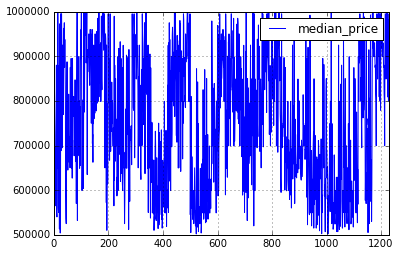

In [306]:
x = DataFrame({'A' : ['foo', 'bar', 'foo', 'bar',
                          'foo', 'bar', 'foo', 'foo'],
                'B' : ['one', 'one', 'two', 'three',
                           'two', 'two', 'one', 'three'],
                'C' : randn(8), 'D' : randn(8)})

In [318]:
grouped = x.groupby('A')
grouped.aggregate(np.sum)

,C,D
A,,
bar,0.393199,-0.020624
foo,-1.815809,2.992605


In [317]:
grouped.head(5)

,A,B,C,D
0,foo,one,0.707217,1.013366
1,bar,one,-1.062683,-0.490737
2,foo,two,-1.555714,0.468668
3,bar,three,0.420470,0.124025
4,foo,two,0.043336,1.789976
5,bar,two,1.035412,0.346087
6,foo,one,-0.638711,-1.696015
7,foo,three,-0.371937,1.416610


In [313]:
x.head(5)

,A,B,C,D
0,foo,one,0.707217,1.013366
1,bar,one,-1.062683,-0.490737
2,foo,two,-1.555714,0.468668
3,bar,three,0.420470,0.124025
4,foo,two,0.043336,1.789976
